<a href="https://colab.research.google.com/github/Khadiza13/DravidianLangTech-NAACL-Misogyny-/blob/main/Visual_only_Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
TRAIN_DATA_PATH = '/kaggle/input/train-dataset/train/train.csv'
EVAL_DATA_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
TEST_DATA_PATH = '/kaggle/input/test-dataset/test/test.csv'
TEST_LABELS_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'
# Load the training data
train_data = pd.read_csv(TRAIN_DATA_PATH)
eval_data = pd.read_csv(EVAL_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)
test_labels=pd.read_csv(TEST_LABELS_PATH)

In [ ]:
train_label_counts = train_data['labels'].value_counts()
eval_label_counts = eval_data['labels'].value_counts()
test_label_counts=test_labels['labels'].value_counts()

# Display the counts
print("Training Data Label Distribution:")
print(train_label_counts)

print("\nValidation Data Label Distribution:")
print(eval_label_counts)

print("\nTest Data Label Distribution:")
print(test_label_counts)

Training Data Label Distribution:
labels
0    381
1    259
Name: count, dtype: int64

Validation Data Label Distribution:
labels
0    97
1    63
Name: count, dtype: int64

Test Data Label Distribution:
labels
0    122
1     78
Name: count, dtype: int64


In [ ]:
train_data.shape

(640, 3)

In [ ]:
eval_data.shape


(160, 3)

In [ ]:
test_data.shape

(200, 2)

In [ ]:
train_data.head()

,image_id,labels,transcriptions
0,888,0,\nഈ ചാടി ഓടി നടക്കണ മനുഷ്യനാണോടാ നിങ്ങളിത്രേം ...
1,554,1,മലയാള സിനിമയുടെ ഭാവി വടറാണി ഇവൾ തന്നെ നല്ല കുഴ...
2,556,1,ഒന്ന് പെറ്റത് ആണെങ്കിലും .. മുലയും വയറും ചാടിയ...
3,484,1,ഓൺലൈൻ പരിചയപ്പെട്ടവനെ കളി തരാമെന്ന് പറഞ്ഞു അപ്...
4,370,0,കാമുകിയും അൺലിമിറ്റഡ് നെറ്റ് ഓഫറുംഉള്ള പയ്യന്റ...


In [ ]:
test_labels.head()

,image_id,labels,transcriptions
0,954,0,ഇതിന് മാത്രം പിള്ളാരെ ഇവർക്കെങ്ങനെ cilşma??....
1,239,0,ഇത് ഞാൻ ചെറുതായിരുന്നപ്പോൾ ഇത് 5ആം ക്ലാസ്സ് വര...
2,61,1,എന്തൊക്കെ ആകിയിട്ടും ഒരു മെന വരുന്നില്ലലോ നിഖി...
3,984,0,ഇഞ്ചുറിക്കു ശേഷം ഇന്റർനാഷണൽ ഫുട്ബോൾലേക്കു തിരി...
4,774,0,* ഡോക്ടർ\nകണ്ണൻ സഹാവ്\nയ്യോ.. ഒരു equipment ഉള...


In [ ]:
import torch
from torch import nn, optim
from transformers import ViTForImageClassification, SwinForImageClassification
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
from PIL import Image
import os
import pandas as pd
import shutil

# Helper function to organize data based on the CSV file
def organize_data_from_csv(csv_path, images_dir, target_dir):
    """
    Organizes images into class-labeled directories based on a CSV file.

    Parameters:
        csv_path (str): Path to the CSV file containing image IDs and labels.
        images_dir (str): Path to the directory containing images.
        target_dir (str): Target directory where images will be organized.
    """
    data = pd.read_csv(csv_path)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for _, row in data.iterrows():
        image_filename = f"{row['image_id']}.jpg"  # Match image filenames
        label = str(row['labels'])  # Convert label to string for folder names
        source_path = os.path.join(images_dir, image_filename)
        class_dir = os.path.join(target_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        if os.path.exists(source_path):
            shutil.copy(source_path, class_dir)

# Paths for your dataset
TRAIN_CSV_PATH = '/kaggle/input/train-dataset/train/train.csv'
TRAIN_IMAGES_DIR = '/kaggle/input/train-dataset/train/'
EVAL_CSV_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
EVAL_IMAGES_DIR = '/kaggle/input/eval-dataset/dev/'
TEST_CSV_PATH = '/kaggle/input/test-dataset/test/test.csv'
TEST_IMAGES_DIR = '/kaggle/input/test-dataset/test/'
TEST_LABELS_IMAGES_DIR = '/kaggle/input/test-with-labels/test_with_labels/'
TEST_LABELS_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'

MERGED_DIR = '/kaggle/working/merged_train_eval'  # Merged train/eval directory
TEST_DIR = '/kaggle/working/test_data'  # Test data directory

# Organize train and evaluation data into the merged directory
organize_data_from_csv(TRAIN_CSV_PATH, TRAIN_IMAGES_DIR, MERGED_DIR)
organize_data_from_csv(EVAL_CSV_PATH, EVAL_IMAGES_DIR, MERGED_DIR)

# Organize test data
organize_data_from_csv(TEST_LABELS_PATH, TEST_LABELS_IMAGES_DIR, TEST_DIR)

# Custom Dataset class for image data
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.csv_path = csv_path
        self.image_dir = image_dir
        self.transform = transform
        self.data = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image and ensure it's in RGB format
        img_name = os.path.join(self.image_dir, f"{self.data.iloc[idx]['image_id']}.jpg")
        image = Image.open(img_name).convert('RGB')  # Convert to RGB if not already
        label = int(self.data.iloc[idx]['labels'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Prepare data transformations (ensure normalization works after converting to RGB)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model norms
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model norms
])

# Load datasets
train_dataset = CustomImageDataset(csv_path=TRAIN_CSV_PATH, image_dir=TRAIN_IMAGES_DIR, transform=train_transforms)
eval_dataset = CustomImageDataset(csv_path=EVAL_CSV_PATH, image_dir=EVAL_IMAGES_DIR, transform=test_transforms)
test_dataset = CustomImageDataset(csv_path=TEST_LABELS_PATH, image_dir=TEST_LABELS_IMAGES_DIR, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained models from Hugging Face (ViT and Swin)
def build_vit_model():
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
    model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
    return model

def build_swin_model():
    model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224")
    model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
    return model

# Choose a model to train
model_name = "Swin"  # Change to "Swin" for Swin Transformer
if model_name == "ViT":
    model = build_vit_model()
elif model_name == "Swin":
    model = build_swin_model()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Evaluation loop
def evaluate_model(model, eval_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(eval_loader, desc="Evaluating"):
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Train the model
train_model(model, train_loader, criterion, optimizer)

# Evaluate the model on the test dataset
true_labels, predicted_labels = evaluate_model(model, test_loader)

# Classification report
report = classification_report(true_labels, predicted_labels, target_names=["Non-Misogyny", "Misogyny"])
print(report)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 20/20 [06:41<00:00, 20.07s/it]


Loss: 0.5089, Accuracy: 75.94%


Epoch 2/5: 100%|██████████| 20/20 [06:19<00:00, 18.99s/it]


Loss: 0.3115, Accuracy: 87.66%


Epoch 3/5: 100%|██████████| 20/20 [06:21<00:00, 19.09s/it]


Loss: 0.2130, Accuracy: 92.03%


Epoch 4/5: 100%|██████████| 20/20 [06:26<00:00, 19.33s/it]


Loss: 0.1461, Accuracy: 95.62%


Epoch 5/5: 100%|██████████| 20/20 [06:25<00:00, 19.29s/it]


Loss: 0.0824, Accuracy: 98.59%


Evaluating: 100%|██████████| 7/7 [00:39<00:00,  5.66s/it]

              precision    recall  f1-score   support

Non-Misogyny       0.87      0.84      0.85       122
    Misogyny       0.76      0.81      0.78        78

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.83       200



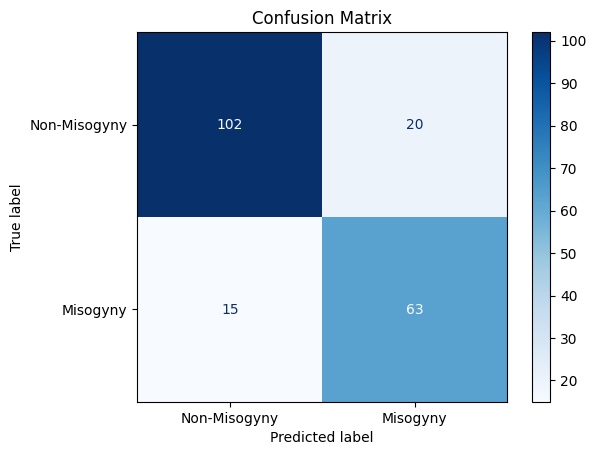

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Misogyny", "Misogyny"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
